<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Como_sincronizar_se%C3%B1ales_desfasadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cómo sincronizar señales con un desfase temporal

Jose Luis López Elvira ([enlace a más recursos en GitHub](https://github.com/joselvira/BiomecanicaPython))

Última modificación 04/01/2022

En ocasiones medimos en una misma persona magnitudes con distintos aparatos simultáneamente, por ejemplo cuando queremos validar un instrumento comparándolo con otro, que hace de *gold standard*. Idealmente estos aparatos están sincronizados en el tiempo, de manera que inician y terminan el registro a la vez. Esto se puede conseguir si los dos aparatos tienen alguna forma de conectarse directamente mediante un **cable de sincronía**, o si están **conectados a un mismo aparato** que recoge todas las señales y las guarda simultáneamente. Otras veces se puede utilizar un **evento de sincronía**, que es una parte de la señal muy característica (por ejemplo un valor máximo brusco) que se puede identificar fácilmente en las señales de los dos instrumentos y que permite alinearlos temporalmente. Esto último no es fácil de conseguir cuando medimos modimientos cíclicos, porque las señales tienden a crear patrones muy parecidos que se van repitiendo sucesivamente. 

Sin embargo, en ocasiones ninguna de estas estrategias es posible y tenemos que recurrir a procedimientos de tratamiento de datos a posteriori. En este caso utillizaremos la :**correlación de Pearson con desplazamiento** y la **correlación cruzada**.

Empezamos importando las librerías que solemos utilizar siempre.

In [178]:
import numpy as np #tipo de datos Numpy
import pandas as pd #tipo de datos Pandas
import xarray as xr #tipo de datos xarray

import matplotlib.pyplot as plt #librería básica para representar gráficas
import seaborn as sns #gráficos avanzados

## Con correlación de Pearson

Empezamos creando unos datos aleatorios que simulan el movimiento de una articulación durante una acción cíclica. La idea es simular una situación en la que medimos lo mismo con dos instrumentos distintos, pero que no están sincronizados, por lo que habrá un desfase temporal aleatorio en sus medidas. Después cogemos un trocito de esa misma señal que esté desfasado en el tiempo.

Para empezar por un ejemplo sencillo, creamos una variable como las que podemos encontrar en análisis de tipo cinemático. Se trata de una onda sinusoidal a la que añadimos un ruido aleatorio para que parezca más real, puesto que cuando medimos movimientos humanos es imposible encontrar dos repeticiones exactamente iguales. Imagina que se trata del ángulo de la rodilla en una persona que pedalea sobre la bicicleta.

Por cierto, puedes consultar otro notebook sobre las características de las señales sinusoidales en [Caracteristicas_de_ondas_sinusoidales](https://github.com/joselvira/BiomecanicaPython/blob/master/Notebooks/Caracteristicas_de_ondas_sinusoidales.ipynb).

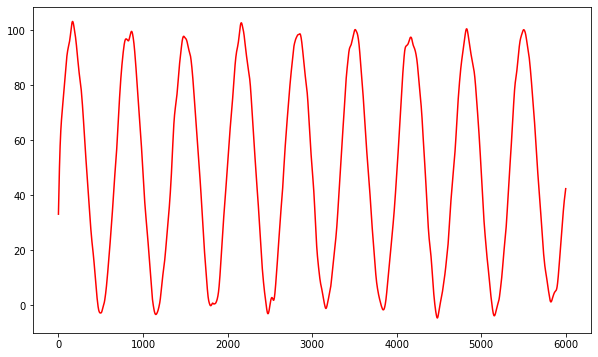

In [179]:
from scipy.signal import butter, filtfilt

np.random.seed(1234) #fija la aleatoriedad para asegurarse la reproducibilidad. Si quieres que cree señales distintas, borra esta línea o déjala como comentario

#calcula array tiempo
duracion = 6.0 #duración del registro en segundos 
Fs = 1000 #frecuencia de muestreo en hercios
Ts = 1./Fs #intervalo de tiempo entre datos en segundos
t = np.arange(0, duracion, Ts)


of = -1 #offset vertical
a = 50 #ampitud
f = 1.5 #frecuencia
af = 0 #ángulo de fase, ángulo al inicio del tiempo

señal = np.array(of + a*np.sin(2*np.pi*f*t + af))

#Crea un ruido aleatorio controlado y después lo filtra
a_err = a*0.4
fc_err = 10
Cf = (2**(1/2)-1)**(1/(2*2)) 
Wn = 2*fc_err/Fs/Cf
b1, a1 = butter(2, Wn, btype = 'low')
ruido = filtfilt(b1, a1, np.random.uniform(a-a_err, a+a_err, len(t)))


#La variable se compone de la suma de señal y ruido, para que tenga un aspecto más aleatorio
instrumento1 = señal + ruido

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento1, color= 'r')
plt.show()

Fíjate en que es una señal cíclica que se va repitiendo en el tiempo, pero hay ligeras diferencias entre una repeticiones y otras.

Después simulamos otra señal, que sería la que mide el otro instrumento, que idealmente sería idéntica a la anterior, aunque esto nunca será así. Para hacerlo más sencillo, creamos otra variable que corresponde a una parte concreta de la anterior, por ejemplo desde el dato 2500 al 4000 (del segundo 2.5 al 4). Eso quiere decir que el instrumento2 empezó a medir 2.5 s después que el 1.

Siendo muy generosos, asumimos que el instrumento2 mide exactamente lo mismo que el instrumento1, pero con ese desfase temporal. Esto no sucederá en la realidad, pero lo hacemos así en el ejemplo para poder tener controlada la capacidad del algoritmo de encontrar el desfase de la señal original.

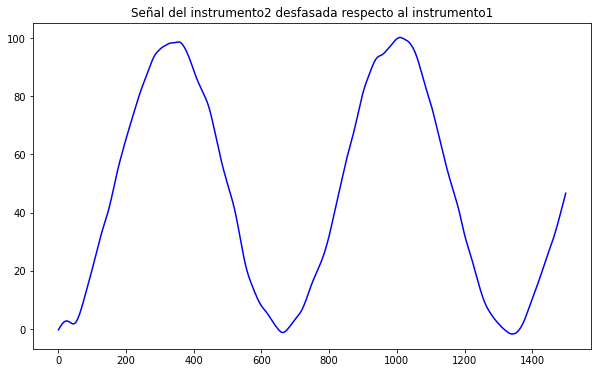

In [180]:
instrumento2 = instrumento1[2500:4000] #la misma señal desfasada un número cualquiera de datos

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento2, color= 'b')
plt.title('Señal del instrumento2 desfasada respecto al instrumento1')
plt.show()

Como las señales de los dos instrumentos están desfasadas, si las representamos juntas no casan.

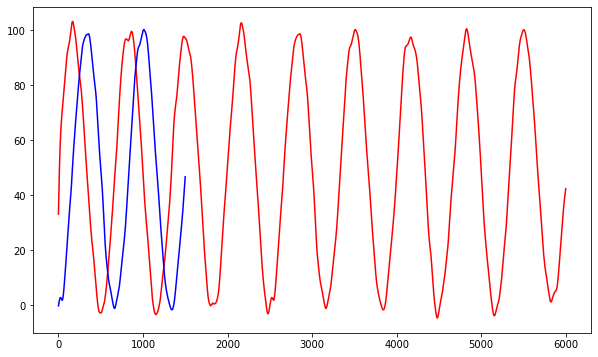

In [181]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento1, color= 'r')
plt.plot(instrumento2, color= 'b')
plt.show()

Necesitamos encontrar una forma de cuantificar en número de datos de desfase entre una señal y otra.

Una solución es ir desplazando la señal del instrumento 2 a lo largo de la señal del instrumento 1 hasta encontrar una posición en la que encajen lo mejor posible. Una de las herramientas matemáticas que podemos utilizar para comparar el perfil de dos curvas es el **coeficiente de correlación**. Dos señales cuyos perfiles sean idénticos, independientemente de su tamaño, obtendrán un coeficiente de correlación de 1. 

Vamos a utilizar el coeficiente de correlación de Pearson del módulo *scipy.stats*.

El siguiente ejemplo ilustra el comportamiento del coeficiente de correlación cuando se comparan dos señales similares pero con diferentes tamaños.

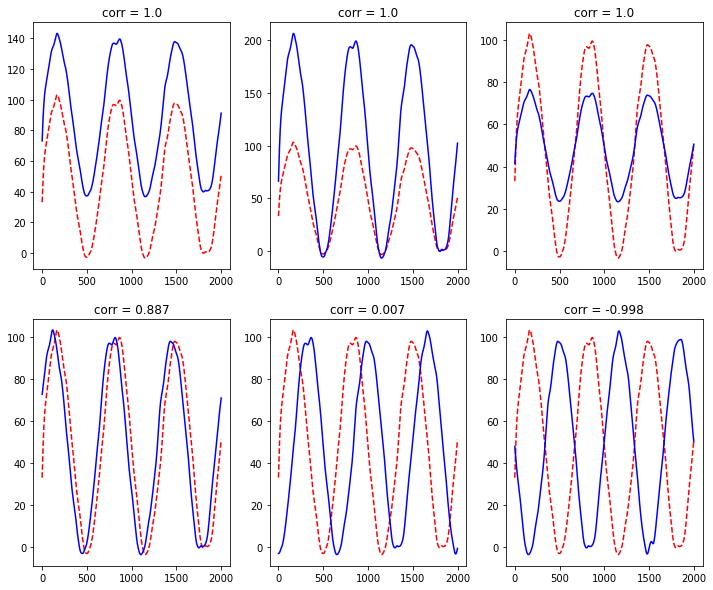

In [182]:
from scipy import stats

señal_original = instrumento1[0:2000]
señal1 = señal_original + 40
señal2 = señal_original*2
señal3 = señal_original/2+25
señal4 = instrumento1[50:2050]
señal5 = instrumento1[500:2500]
señal6 = instrumento1[1000:3000]

comp1 = stats.pearsonr(señal_original, señal1)[0]
comp2 = stats.pearsonr(señal_original, señal2)[0]
comp3 = stats.pearsonr(señal_original, señal3)[0]
comp4 = stats.pearsonr(señal_original, señal4)[0]
comp5 = stats.pearsonr(señal_original, señal5)[0]
comp6 = stats.pearsonr(señal_original, señal6)[0]


fig, ax = plt.subplots(2,3, figsize=(12,10))
ax[0,0].plot(señal_original, '--', color= 'r')
ax[0,0].plot(señal1, '-', color= 'b')

ax[0,1].plot(señal_original, '--', color= 'r')
ax[0,1].plot(señal2, '-', color= 'b')

ax[0,2].plot(señal_original, '--', color= 'r')
ax[0,2].plot(señal3, '-', color= 'b')

ax[1,0].plot(señal_original, '--', color= 'r')
ax[1,0].plot(señal4, '-', color= 'b')

ax[1,1].plot(señal_original, '--', color= 'r')
ax[1,1].plot(señal5, '-', color= 'b')

ax[1,2].plot(señal_original, '--', color= 'r')
ax[1,2].plot(señal6, '-', color= 'b')

ax[0,0].set_title('corr = '+ str(round(comp1,3)))
ax[0,1].set_title('corr = '+ str(round(comp2,3)))
ax[0,2].set_title('corr = '+ str(round(comp3,3)))
ax[1,0].set_title('corr = '+ str(round(comp4,3)))
ax[1,1].set_title('corr = '+ str(round(comp5,3)))
ax[1,2].set_title('corr = '+ str(round(comp6,3)))
plt.show()


Como se puede ver en las gráficas anteriores, el coeficiente de correlación es sensible a la forma de las señales pero no a su proporcionalidad. En los tres casos de la fila superior el coeficiente es 1 porque las dos señales tienen el mismo perfil de sibidas y bajadas, aqunque estén separadas verticalmente o sean proporcionalmente mayores o menores. Sin embargo, en la fila inferior, son exactamente las mismas señales pero desfasadas en el tiempo, es decir, la señal roja se desplaza hacia la derecha, y eso hace que el coeficiente de correlación descienda sensiblemente, hasta el punto de ser cercano a -1 cuando las señales se encuentran en *antifase* (cuando una sube la otra baja y al revés).

Lo que necesitamos concretamente en nuestro ejemplo, es la posición en la que las la señal del instrumento2 encaja perfectamente con la del instrumento1, es decir, la correlación es lo más cercana a 1.

Lo que haremos será crear un bucle *for* que recorra la señal del instrumento1 e iremos calculando la correlación de la señal del instrumento2 con una parte del instrumento1 del mismo tamaño. La posición en la que la correlación sea más alta, será la que indica un mejor ajuste y por tanto nos indicará el desfase entre las dos.

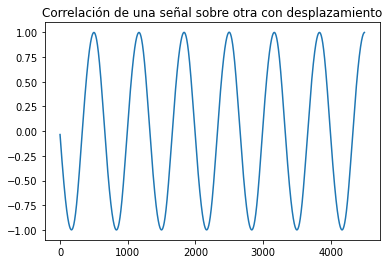

In [183]:
corr=[] #lista donde iremos guardando los valores de correlación
for i in range(len(instrumento1)-len(instrumento2)):
  instr1_cortado = instrumento1[i:i+len(instrumento2)]
  corr.append(stats.pearsonr(instr1_cortado, instrumento2)[0])

plt.plot(corr)
plt.title('Correlación de una señal sobre otra con desplazamiento')
plt.show()

En el gráfico anterior se muestran los valores de la correlación del instrumento1 con el 2 cuando se van comparando al deslizarlo en el tiempo hacia la derecha. Los valores oscilan entre 1 (cuando la coincidencia es plena, están *en fase*) y -1 (cuando las señales oscilan inversamente, están en *antifase*).

La correlación será máxima cuando se produzca la mayor coincidencia. Aunque en la gráfica parezca que oscila entre 1 y -1, realmente hay un valor de máxima coincidencia, por lo que si buscamos la posición en la que la correlación es máxima, nos dará el desfase de una de las señales sobre la otra.

In [184]:
corr_max = np.max(corr) #devuelve el índice (posición) donde se encuentra el máximo valor del array
desfase = np.argmax(corr)
print(f'La máxima correlación es {corr_max}, y se encuentra en la posición {desfase}')

La máxima correlación es 0.9999999999999998, y se encuentra en la posición 2500


La mayor correlación que se encuentra es muy cercana a 1 y se produce cuando la señal del instrumento2 se encuentra 2500 posiciones a la derecha de la señal del instrumento1, que es como lo habíamos creado al principio.

Para comprobar que coinciden, creamos un gráfico con las dos señales superpuestas con el mejor ajuste encontrado. En el gráfico las dos señales encajan a la perfección.

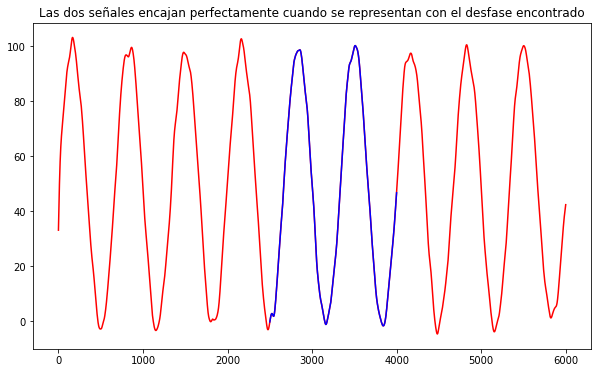

In [185]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento1, color= 'r')
plt.plot(np.arange(desfase, desfase+len(instrumento2)), instrumento2, color= 'b')
plt.title('Las dos señales encajan perfectamente cuando se representan con el desfase encontrado')
plt.show()

En otras ocasiones necesitamos trabajar con señales mucho más ruidosas, como podrían ser las de electromiografía, con las que es más difícil encontrar sincronización manualmente.

Vamos a crear dos señales que simulan esta situación. Hacemos lo mismo que anteriormente, crearemos la señal de un instrumento (lo llamaremos instrumento11), y tomamos de él un trozo para el otro instrumento, al que llamaremos instrumento22. Por ejemplo lo desfasamos 1400 datos hacia la derecha.

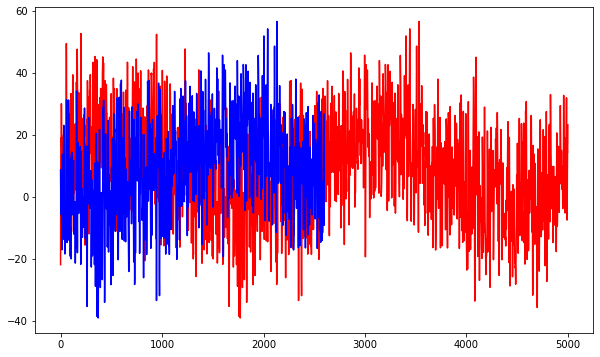

In [186]:
from scipy.signal import butter, filtfilt

np.random.seed(1234) #fija la aleatoriedad para asegurarse la reproducibilidad

#calcula array tiempo
duracion = 5.0 #duración del registro en segundos 
Fs = 1000 #frecuencia de muestreo en hercios
Ts = 1./Fs #intervalo de tiempo entre datos en segundos
t = np.arange(0, duracion, Ts)


of = -1 #offset vertical
a = 10 #ampitud
f = 0.4 #frecuencia
af = 0 #ángulo de fase, ángulo al inicio del tiempo

señal = np.array(of + a*np.sin(2*np.pi*f*t + af))

#Crea un ruido aleatorio controlado y lo filtra
a_err = a*5.0
fc_err = 100
Cf = (2**(1/2)-1)**(1/(2*2)) 
Wn = 2*fc_err/Fs/Cf
b1, a1 = butter(2, Wn, btype = 'low')
ruido = filtfilt(b1, a1, np.random.uniform(a-a_err, a+a_err, len(t)))

#La variable se compone de la suma de señal y ruido, para que tenga un aspecto más aleatorio
instrumento11 = señal + ruido

instrumento22 = instrumento11[1400:4000] #la misma señal desfasada un número cualquiera de datos

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento11, color= 'r')
plt.plot(instrumento22, color= 'b')
plt.show()

Aplicamos el procedimiento anterior para encontrar la mejor correlación.

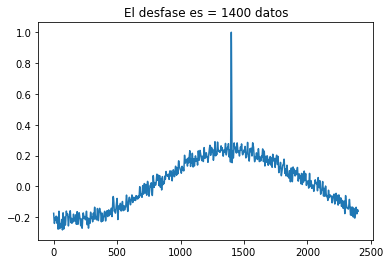

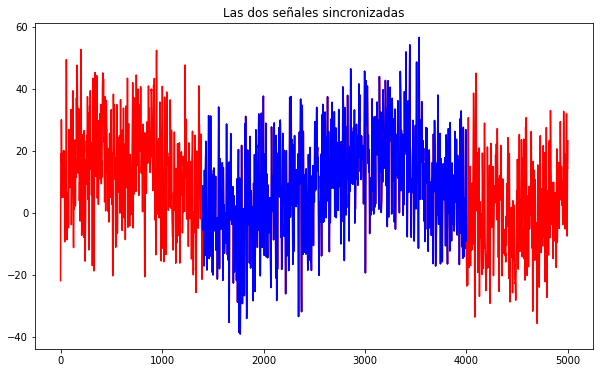

In [187]:
corr=[] #lista donde iremos guardando los valores de correlación
for i in range(len(instrumento11)-len(instrumento22)):
  instr11_cortado = instrumento11[i:i+len(instrumento22)]
  corr.append(stats.pearsonr(instr11_cortado, instrumento22)[0])
desfase = np.argmax(corr)

plt.plot(corr)
plt.title(f'El desfase es = {desfase} datos')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento11, color= 'r')
plt.plot(np.arange(desfase, desfase+len(instrumento22)), instrumento22, color= 'b')
plt.title('Las dos señales sincronizadas')
plt.show()

## Con correlación cruzada

La correlación cruzada o *cross-correlation*, es otro de los procedimientos que se pueden utilizar para sincronizar señales. Es especialmente indicado en señales muy ruidosas, y es mucho más rápido que el método anterior, algo que se hace notable cuando tratamos conjuntos de señales ámplios y largos. La propia función se encarga de desplazar una señal sobre la otra, lo que simplifica el proceso.

Esta técnica requiere que las dos señales tengan un número de datos igual, por lo que si una es más corta que la otra, tendremos que rellenarle ceros al final hasta igualar su longitud con la otra. También es necesario normalizar las señales, esto se hace restando a cada señal su media y dividiendo entre su desviación típica.

Sin embargo tiene el inconveniente de que es muy sensible a la proporción de señal y ruido, por lo que no suele encontrar el ajuste exacto en señales poco ruidosas.

Vamos a probar con los ejemplos anteriores, primero con la señal de tipo electromiográfico y después con la de tipo cinemático.


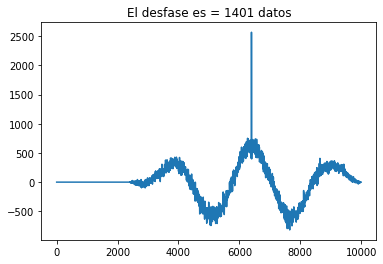

In [188]:
from scipy import signal

#Es necesario normalizar las señales
dat1 = (instrumento11-np.mean(instrumento11))/np.std(instrumento11)
dat2 = (instrumento22-np.mean(instrumento22))/np.std(instrumento22)

#Rellena con ceros la señal más corta
if (len(dat1) != len(dat2)):    
    if (len(dat1) < len(dat2)):
        dat1 = np.append(dat1, np.zeros(len(dat2) - len(dat1)))
    else:
        dat2 = np.append(dat2, np.zeros(len(dat1) - len(dat2)))

#Calcula la correlación cruzada
ccorr = signal.correlate(dat1, dat2, 'full')

desfase = int(np.ceil(np.argmax(ccorr) - (len(ccorr)) / 2)+1)

plt.plot(ccorr)
plt.title(f'El desfase es = {desfase} datos')
plt.show()

Se puede ver claramente en la gráfica un máximo muy sobresaliente, que coindice con el desfase encontrado con la correlación de Pearson.

Sin embargo, con datos menos ruidosos en ocasiones no funciona del todo bien esta técnica. Veamos qué pasa si la utilizamos con los datos del primer ejemplo (instrumento1 e instrumento2).

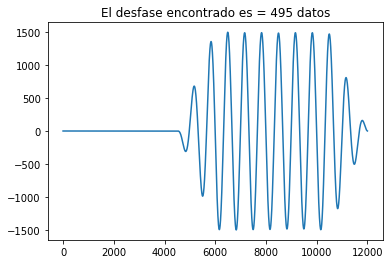

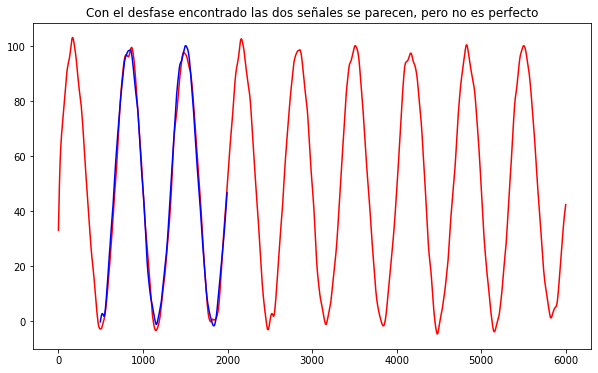

In [189]:
# es necesario normalizar las señales
dat1 = (instrumento1-np.mean(instrumento1))/np.std(instrumento1)
dat2 = (instrumento2-np.mean(instrumento2))/np.std(instrumento2)

#Rellena con ceros la señal más corta
if (len(dat1) != len(dat2)):    
    if (len(dat1) < len(dat2)):
        dat1 = np.append(dat1, np.zeros(len(dat2) - len(dat1)))
    else:
        dat2 = np.append(dat2, np.zeros(len(dat1) - len(dat2)))

#Calcula la correlación cruzada
ccorr = signal.correlate(dat1, dat2, 'full')

desfase = int(np.ceil(np.argmax(ccorr) - (len(ccorr)) / 2)+1)

plt.plot(ccorr)
plt.title(f'El desfase encontrado es = {desfase} datos')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento1, color= 'r')
plt.plot(np.arange(desfase, desfase+len(instrumento2)), instrumento2, color= 'b')
plt.title('Con el desfase encontrado las dos señales se parecen, pero no es perfecto')
plt.show()


En la gráfica anterior se ve que el ajuste de la señal se asemeja bastante al original, pero no es perfecto, puesto que habíamos creado la señal con un desfase de 2500 datos más a la derecha, y el mejor ajuste que ha encontrado es con un desfase de 494.

Una forma de perfeccionar el algoritmo consiste en pasar a la función *signal.correlate* **la segunda derivada** de las señales originales. Cuando hacemos una derivada se produce el efecto colateral de magnificar el ruido de la señal, algo que en este caso es beneficioso porque hace más eficaz la detección del desfase entre las dos señales. Lo probamos con el ejemplo anterior. La derivada se puede calcular con la función *gradient()* de la librería *Numpy*.

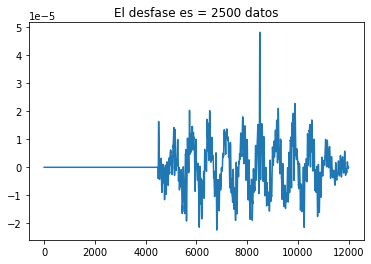

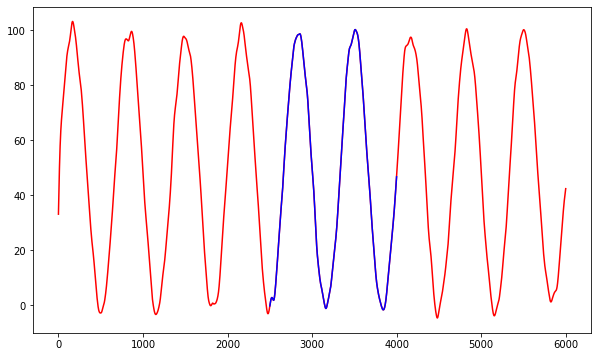

In [190]:
#Correlación cruzada con doble derivada
ccorr = signal.correlate(np.gradient(np.gradient(dat1)), np.gradient(np.gradient(dat2)), 'full')

desfase = int(np.ceil(np.argmax(ccorr) - (len(ccorr)) / 2)+1)

plt.plot(ccorr)
plt.title(f'El desfase es = {desfase} datos')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(instrumento1, color= 'r')
plt.plot(np.arange(desfase, desfase+len(instrumento2)), instrumento2, color= 'b')
plt.show()

De esta forma se ha corregido el problema y ha funcionado correctamente, pero va a depender de lo ruidosas que sean las señales que funcione mejor o peor.

En la siguiente celda está puesto todo junto para crear las señales y calcular el desfase según la correlación de Pearson y según la correlación cruzada. Cada vez que se ejecuta la celda crea unas señales nuevas de forma aleatoria (respetando las características de las ondas que se le indican), de manera que puedes modificar los parámetros y probar en las gráficas de abajo si coinciden las dos técnicas o no. Es interesante comprobar que cuando la frecuencia del error de la señal (variable *fc_err*) es baja, el algoritmo de la correlación cruzada hay veces que acierta y otras que se equivoca por poco, pero otras veces se equivoca por varios números de datos, aunque aparentemente en la gráfica las dos señales se parezcan bastante.

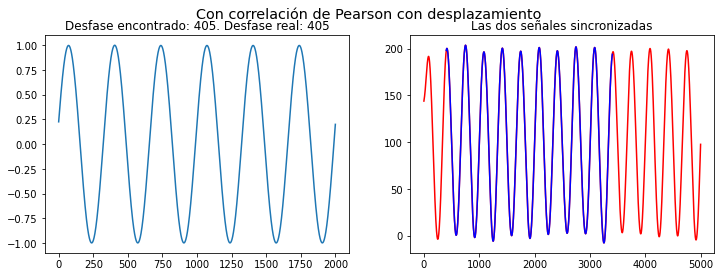

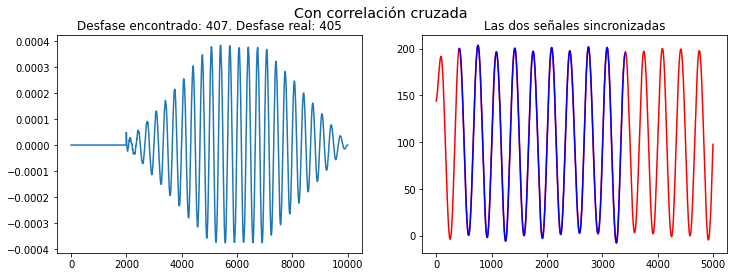

In [191]:
from scipy.signal import butter, filtfilt

#np.random.seed(1234) #fija la aleatoriedad para asegurarse la reproducibilidad

#---------------------------
#Variables a modificar
desfase_real = 405

#Características de la señal
a = 100.0 #ampitud
f = 3.0 #frecuencia

#Características del ruido
a_err = 50.0 #ampitud
fc_err = 5 #frecuencia
#---------------------------

#calcula array tiempo
duracion = 5.0 #duración del registro en segundos 
Fs = 1000 #frecuencia de muestreo en hercios
Ts = 1./Fs #intervalo de tiempo entre datos en segundos
t = np.arange(0, duracion, Ts)

of = -1 #offset vertical
af = 0 #ángulo de fase, ángulo al inicio del tiempo

señal = np.array(of + a*np.sin(2*np.pi*f*t + af))

#Crea un ruido aleatorio controlado y lo filtra
Cf = (2**(1/2)-1)**(1/(2*2)) 
Wn = 2*fc_err/Fs/Cf
b1, a1 = butter(2, Wn, btype = 'low')
ruido = filtfilt(b1, a1, np.random.uniform(a-a_err, a+a_err, len(t)))

#La variable se compone de la suma de señal y ruido, para que tenga un aspecto más aleatorio
variable1 = señal + ruido

variable2 = variable1[desfase_real:desfase_real+3000] #la misma señal desfasada un número cualquiera de datos


#------------------------------------------
#Con correlación de Pearson
corr=[] #lista donde iremos guardando los valores de correlación
for i in range(len(variable1)-len(variable2)):
  variable1_cortado = variable1[i:i+len(variable2)]
  corr.append(stats.pearsonr(variable1_cortado, variable2)[0])
desfase_corr = np.argmax(corr)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(corr)
ax[0].set_title(f'Desfase encontrado: {desfase_corr}. Desfase real: {desfase_real}')

ax[1].plot(variable1, color= 'r')
ax[1].plot(np.arange(desfase_corr, desfase_corr+len(variable2)), variable2, color= 'b')
ax[1].set_title('Las dos señales sincronizadas')
plt.suptitle('Con correlación de Pearson con desplazamiento', fontsize='x-large')
plt.show()
#------------------------------------------

#------------------------------------------
#Con correlación cruzada con doble derivada
# es necesario normalizar las señales
dat1 = (variable1-np.mean(variable1))/np.std(variable1)
dat2 = (variable2-np.mean(variable2))/np.std(variable2)

#Rellena con ceros la señal más corta
if (len(dat1) != len(dat2)):    
    if (len(dat1) < len(dat2)):
        dat1 = np.append(dat1, np.zeros(len(dat2) - len(dat1)))
    else:
        dat2 = np.append(dat2, np.zeros(len(dat1) - len(dat2)))

ccorr = signal.correlate(np.gradient(np.gradient(dat1)), np.gradient(np.gradient(dat2)), 'full')
desfase_ccorr = int(np.ceil(np.argmax(ccorr) - (len(ccorr)) / 2)+1)


fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ccorr)
ax[0].set_title(f'Desfase encontrado: {desfase_ccorr}. Desfase real: {desfase_real}')

ax[1].plot(variable1, color= 'r')
ax[1].plot(np.arange(desfase_ccorr, desfase_ccorr+len(variable2)), variable2, color= 'b')
ax[1].set_title('Las dos señales sincronizadas')
plt.suptitle('Con correlación cruzada', fontsize='x-large')
plt.show()
#------------------------------------------


# Datos más complejos en varias dimensiones

A continuación probaremos cómo funcionan en un ejemplo más parecido a una situación real. Tendríamos mediciones con dos instrumentos distintos registrando simultáneamente a un grupo de personas. Creamos una muestra aleatoria de una variable medida dos veces (pre y post), después se coge un trozo de la misma señal desplazado un número de datos cualquiera.

En este caso creamos la muestra en *Pandas* y después la pasamos a la estructura de datos *DataArray* de la librería *Xarray*, que permite hacer cálculos con mucha rapidez (funcina parecido a *Numpy*) pero sin renunciar al etiquetado de las variables de *Pandas*. Si no estás familiarizado con la librería *xarray* merece la pena dedicarle un tiempo porque se le puede sacar mucho partido a la hora de analizar datos.

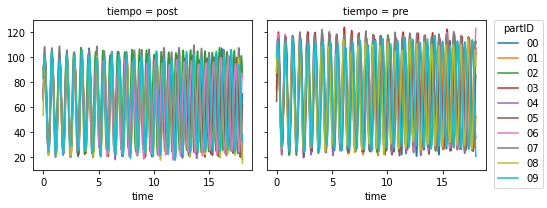

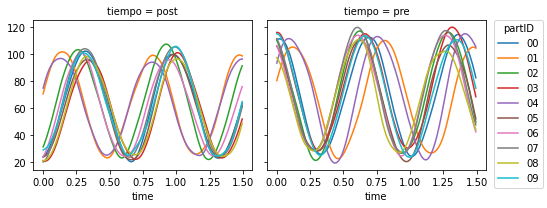

In [192]:
def crea_muestra_continua(num_suj=10, Fs=100.0, IDini=0, rango_offset = [-2.0, -0.5], rango_amp = [1.0, 2.2], rango_frec = [1.8, 2.4], rango_af=[0.0, 1.0], rango_duracion=[5.0, 5.1], amplific_ruido=[0.4, 0.7], fc_ruido=[7.0, 12.0]):
    from scipy.signal import butter, filtfilt

    sujeto=[]
    for suj in range(num_suj):
        
        a = np.random.uniform(rango_amp[0], rango_amp[1])
        of = np.random.uniform(rango_offset[0], rango_offset[1])
        f =  np.random.uniform(rango_frec[0], rango_frec[1])
        af =  np.deg2rad(np.random.uniform(rango_af[0], rango_af[1])) #lo pasa a radianes
        err = a * np.random.uniform(amplific_ruido[0], amplific_ruido[1])
        fc_err = np.random.uniform(fc_ruido[0], fc_ruido[1])
        duracion = np.random.uniform(rango_duracion[0], rango_duracion[1])
        
        Ts = 1./Fs #intervalo de tiempo entre datos en segundos
        t = np.arange(0, duracion, Ts)

        senal = np.array(of + a*np.sin(2*np.pi*f*t + af))
        
        #Crea un ruido aleatorio controlado
        pasadas = 2.0 #nº de pasadas del filtro adelante y atrás
        orden = 2
        Cf = (2**(1/pasadas)-1)**(1/(2*orden)) #correction factor. Para 2nd order = 0.802 
        Wn = 2*fc_err/Fs/Cf
        b1, a1 = butter(orden, Wn, btype = 'low')
        ruido = filtfilt(b1, a1, np.random.uniform(a-err, a+err, len(t)))
        
        
        #################################
        sujeto.append(pd.DataFrame(senal + ruido, columns=['value']).assign(**{'partID':'{0:02d}'.format(suj+IDini), 'time':np.arange(0, len(senal)/Fs, 1/Fs)}))
    return pd.concat(sujeto)

np.random.seed(12340) #fija la aleatoriedad para asegurarse la reproducibilidad
n = 10 #número de participantes
duracion = 6 #duración del registro
frec = 200.0 #frecuencia del registro
Pre_v1 = crea_muestra_continua(n, Fs=frec, IDini=0, rango_offset = [25, 29], rango_amp = [40, 45], rango_frec = [1.48, 1.52], rango_af=[0, 30], amplific_ruido=[0.4, 0.7], fc_ruido=[3.0, 3.5], rango_duracion=[duracion*3, duracion*3]).assign(**{'tiempo':'pre'})
Post_v1 = crea_muestra_continua(n, Fs=frec, IDini=0, rango_offset = [22, 26], rango_amp = [36, 40], rango_frec = [1.48, 1.52], rango_af=[0, 30], amplific_ruido=[0.4, 0.7], fc_ruido=[3.0, 3.5], rango_duracion=[duracion*3, duracion*3]).assign(**{'tiempo':'post'})
#Pre_v2 = crea_muestra_continua(n, Fs=frec, IDini=0, rango_offset = [35, 39], rango_amp = [50, 55], rango_frec = [1.48, 1.52], rango_af=[0, 30], amplific_ruido=[0.4, 0.7], fc_ruido=[3.0, 3.5], rango_duracion=[duracion, duracion]).assign(**{'tiempo':'pre'})
#Post_v2 = crea_muestra_continua(n, Fs=frec, IDini=0, rango_offset = [32, 36], rango_amp = [32, 45], rango_frec = [1.48, 1.52], rango_af=[0, 30], amplific_ruido=[0.4, 0.7], fc_ruido=[3.0, 3.5], rango_duracion=[duracion, duracion]).assign(**{'tiempo':'post'})

dfInstrumento1 = pd.concat([Pre_v1, Post_v1]).reset_index()
dfInstrumento1 = dfInstrumento1[['partID', 'tiempo', 'time', 'value']] #Reordena los factores

#dfTodos2 = pd.concat([Pre_v2, Post_v2]).reset_index()
#dfTodos2 = dfTodos2[['partID', 'tiempo', 'time', 'value']] #Reordena los factores

#sns.relplot(data=dfTodosArchivos, x='time', y='value',  col='tiempo', units='partID', estimator=None, hue='partID',  kind='line')

#Pasa a dataarray
daInstrumento1 = dfInstrumento1.set_index(['partID', 'tiempo', 'time']).to_xarray().to_array()
del daInstrumento1['variable']
daInstrumento1 = daInstrumento1.squeeze('variable')
daInstrumento1.attrs['frec'] = frec

daInstrumento2 = daInstrumento1.isel(time=slice(300, 600)).copy() #copia un trozo de las señales del instrumento 1
daInstrumento2 = daInstrumento2.assign_coords(time=np.arange(0,len(daInstrumento2.time))/frec) #reajusta a cero las coordenadas de la dimensión tiempo
daInstrumento2.loc[dict(tiempo='post')] = daInstrumento1.sel(tiempo='post').isel(time=slice(500, 800)).assign_coords(time=(daInstrumento2.time)) #desfasa los datos del post de manera diferente
daInstrumento2.loc[dict(partID=['01', '04'])] = daInstrumento1.sel(partID=['01', '04']).isel(time=slice(400, 700)).assign_coords(time=(daInstrumento2.time)) #desfasa los datos del post de manera diferente
daInstrumento1.plot.line(x='time', col='tiempo', hue='partID')
daInstrumento2.plot.line(x='time', col='tiempo', hue='partID')

Primero creamos una función auxiliar que tratará cada array 1D por separado, y luego la función de *xarray* *apply_ufunc*, que va alimentando a la función auxiliar con dada señal 1D de la variable total *daInstrumento1*.

In [193]:
from scipy import stats
    
def cross_correl_aux(datos1, datos2, tam, nom, pot):
    #pre-crea el array donde guardará las correlaciones de cada desfase
    corr=np.full(tam, np.nan)
    
    try:
        dat1 = datos1[~np.isnan(datos1)] #quita nans del final para función stats.pearson
        dat2 = datos2[~np.isnan(datos2)]
        
        for i in range(0, dat1.size - dat2.size):
            corr[i] = stats.pearsonr(dat1[i:i+dat2.size], dat2)[0]
            
    except Exception as err:
        print('Error de cálculo, posiblemente vacío', err)
        
    return corr #si hay algún error, lo devuelve vacío

daCrosscorr = xr.apply_ufunc(cross_correl_aux,  #nombre de la función
                  #daiSen.sel(articulacion='rodilla', lado='L', eje='x').dropna(dim='time'),
                  daInstrumento1,
                  daInstrumento2,#.sel(partID=da1['partID'], tiempo='pre'),
                  daInstrumento1.time.size - daInstrumento2.time.size,
                  daInstrumento1['partID'],
                  daInstrumento1['tiempo'],                                    
                  input_core_dims=[['time'], ['time'], [], [], []],  #lista con una entrada por cada argumento
                  output_core_dims=[['lag']],  #datos que devuelve
                  exclude_dims=set(('lag', 'time',) ),  #dimensiones que se permite que cambien (tiene que ser un set)
                  #dataset_fill_value=np.nan,
                  vectorize=True,
                  dask='parallelized',
                  keep_attrs=False,
                  #kwargs=args_func_cortes,
                  ).dropna(dim='lag', how='all')
daCrosscorr = daCrosscorr.assign_coords(lag=range(len(daCrosscorr.lag)))

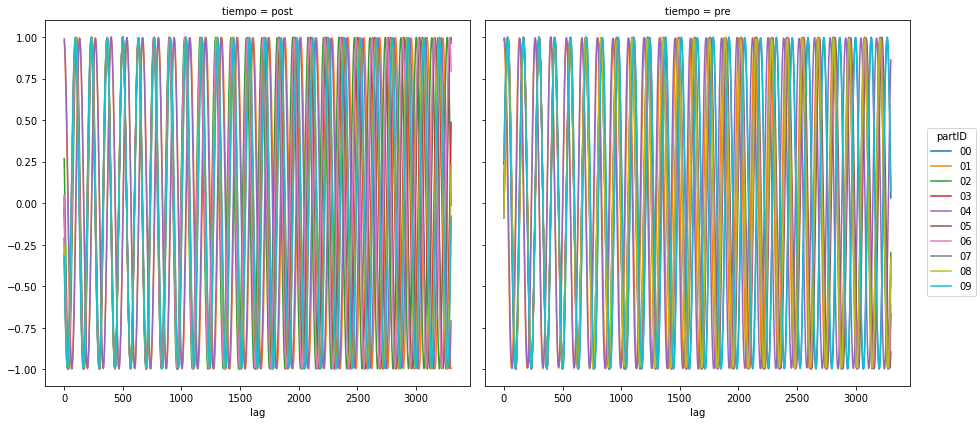

In [194]:
#Gráfica con todas las correlaciones encontradas
daCrosscorr.plot.line(x='lag', hue='partID', col='tiempo', size=6)

A continuación extraemos el desfase que se produce en cada participante y tiempo a partir del valor máximo del coeficiente de correlación.

Puedes ver que los desfases coinciden con lo que habíamos creado artificialmente al principio.

In [195]:
daOffset_corr = daCrosscorr.lag[daCrosscorr.argmax(dim='lag')] #se queda con el índice teniendo en cuenta el signo
daOffset_corr

<xarray.DataArray 'lag' (partID: 10, tiempo: 2)>
array([[500, 300],
       [400, 400],
       [500, 300],
       [500, 300],
       [400, 400],
       [500, 300],
       [500, 300],
       [500, 300],
       [500, 300],
       [500, 300]])
Coordinates:
    lag      (partID, tiempo) int64 500 300 400 400 500 ... 300 500 300 500 300
  * partID   (partID) object '00' '01' '02' '03' '04' '05' '06' '07' '08' '09'
  * tiempo   (tiempo) object 'post' 'pre'

Puedes probar a cambiar el número de participantes, la duración de los registros, las frecuencias, etc. Podrás darte cuenta de que cuando el número de participantes y la duración de los registros aumentan, aumenta considerablemente el tiempo que tarda en procesar las correlaciones.

Como decíamos anteriormente, el algoritmo de la correlación cruzada es mucho más rápido, aunque también decíamos que su precisión depende de las características de las señales. A continuación puedes ver cómo funciona este método siguiendo la misma estructura del ejemplo anterior. Lo que cambia básicamente es la función auxiliar.

In [196]:
from scipy import signal
    
def cross_correl_aux(datos1, datos2, tam, nom, pot):
    #Quita Nans
    dat1 = datos1[~np.isnan(datos1)]
    dat2 = datos2[~np.isnan(datos2)]
    
    #Normaliza
    dat1 = (dat1-np.mean(dat1))/np.std(dat1)
    dat2 = (dat2-np.mean(dat2))/np.std(dat2)
    
    #Rellena con ceros
    if (len(dat1) != len(dat2)):
        if (len(dat1) < len(dat2)):
            dat1 = np.append(dat1, np.zeros(len(dat2) - len(dat1)))
        else:
            dat2 = np.append(dat2, np.zeros(len(dat1) - len(dat2)))

    #Calcula la correlación cruzada
    ccorr = signal.correlate(np.gradient(np.gradient(dat1)), np.gradient(np.gradient(dat2)), 'full')
    desfase = int(np.ceil(np.argmax(corr) - (len(corr)) / 2)+1)
    
    return ccorr[int(len(ccorr)/2):]

daCrosscorr = xr.apply_ufunc(cross_correl_aux,  #nombre de la función
                  #daiSen.sel(articulacion='rodilla', lado='L', eje='x').dropna(dim='time'),
                  daInstrumento1,
                  daInstrumento2,#.sel(partID=da1['partID'], tiempo='pre'),
                  daInstrumento1.time.size - daInstrumento2.time.size,
                  daInstrumento1['partID'],
                  daInstrumento1['tiempo'],                                    
                  input_core_dims=[['time'], ['time'], [], [], []],  #lista con una entrada por cada argumento
                  output_core_dims=[['lag']],  #datos que devuelve
                  exclude_dims=set(('lag', 'time',) ),  #dimensiones que se permite que cambien (tiene que ser un set)
                  #dataset_fill_value=np.nan,
                  vectorize=True,
                  dask='parallelized',
                  keep_attrs=False,
                  #kwargs=args_func_cortes,
                  ).dropna(dim='lag', how='all')
daCrosscorr = daCrosscorr.assign_coords(lag=range(len(daCrosscorr.lag)))

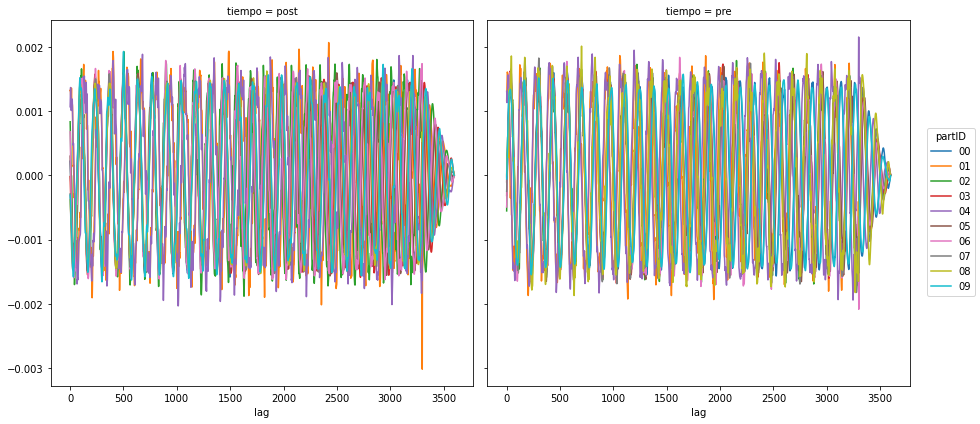

In [197]:
#Gráfica con todas las correlaciones encontradas
daCrosscorr.plot.line(x='lag', hue='partID', col='tiempo', size=6)

Fíjate en que con este método tarda mucho menos en hacer todos los cálculos. Sin embargo, como ya se comentó anteriormente, en casos como este con poco ruido en las señales la precisión es menor, en algunas medidas se aproxima mucho al desfase real que habíamos creado, pero en otros no.

In [198]:
daOffset_ccorr = daCrosscorr.lag[daCrosscorr.argmax(dim='lag')] #se queda con el índice teniendo en cuenta el signo
daOffset_ccorr

<xarray.DataArray 'lag' (partID: 10, tiempo: 2)>
array([[1170,  301],
       [2423, 1060],
       [ 503, 2154],
       [ 501, 2554],
       [ 678, 3299],
       [2499, 2034],
       [ 896, 1621],
       [ 366,  171],
       [1843,  702],
       [ 500, 1655]])
Coordinates:
    lag      (partID, tiempo) int64 1170 301 2423 1060 503 ... 1843 702 500 1655
  * partID   (partID) object '00' '01' '02' '03' '04' '05' '06' '07' '08' '09'
  * tiempo   (tiempo) object 'post' 'pre'